In [34]:
import torch
import torch.nn.functional as F
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel
from torch.utils.tensorboard import SummaryWriter
import pytorch_lightning as pl
import random
import dotenv
import omegaconf
import hydra
import logging
import wandb
from datetime import date
import dotenv
import os
import pathlib
from typing import Dict, Any
from copy import deepcopy

from rigl_torch.models import ModelFactory
from rigl_torch.rigl_scheduler import RigLScheduler
from rigl_torch.rigl_constant_fan import RigLConstFanScheduler
from rigl_torch.datasets import get_dataloaders
from rigl_torch.optim import (
    get_optimizer,
    get_lr_scheduler,
)
from rigl_torch.utils.checkpoint import Checkpoint
from rigl_torch.utils.rigl_utils import get_T_end, get_fan_in_after_ablation, get_conv_idx_from_flat_idx
from hydra import initialize, compose



In [35]:
with initialize("../configs", version_base="1.2.0"):
    cfg = compose(
        "config.yaml",
        overrides=[
            "dataset=cifar10",
            "compute.distributed=False",
            "model=resnet18"
            ])
dotenv.load_dotenv("../.env")
os.environ["IMAGE_NET_PATH"]
print(cfg.model.name)


resnet18


In [135]:
run_id = "f75f6a5m" # us1p7psr (no dyn ablation), 8m2ytv3b (0.01), ek5wjcyn (0.1), f75f6a5m (0.5)
rank=0
ckpt_path="/Users/annago/Desktop/current_projects/work_w_UCalgary/checkpointsA"

checkpoint = Checkpoint.load_last_checkpoint(run_id=run_id, parent_dir = ckpt_path)
#checkpoint=None
if checkpoint is not None:
    run_id = checkpoint.run_id
    optimizer_state = checkpoint.optimizer
    scheduler_state = checkpoint.scheduler
    pruner_state = checkpoint.pruner
    model_state = checkpoint.model
    cfg = checkpoint.cfg
else:
    run_id, optimizer_state, scheduler_state, pruner_state, model_state = (
        None,
        None,
        None,
        None,
        None,
    )


    # cfg.compute.distributed=False
    
pl.seed_everything(cfg.training.seed)
use_cuda = not cfg.compute.no_cuda and torch.cuda.is_available()
# if not use_cuda:
#     raise SystemError("GPU has stopped responding...waiting to die!")
#     logger.warning(
#         "Using CPU! Verify cfg.compute.no_cuda and "
#         "torch.cuda.is_available() are properly set if this is unexpected"
#     )


if cfg.compute.distributed and use_cuda:
    device = torch.device(f"cuda:{rank}")
else:
    print(f"loading to device rank: {rank}")
    device = torch.device(f"cuda:{rank}")
if not use_cuda:
    device = torch.device("cuda" if use_cuda else "cpu")
# train_loader, test_loader = get_dataloaders(cfg)

model = ModelFactory.load_model(
    model=cfg.model.name, dataset=cfg.dataset.name
)
model.to(device)
if cfg.compute.distributed:
    model = DistributedDataParallel(model, device_ids=[rank])
if model_state is not None:
    try:
        model.load_state_dict(model_state)
    except RuntimeError:
        model_state = checkpoint.get_single_process_model_state_from_distributed_state()
        model.load_state_dict(model_state)
        
optimizer = get_optimizer(cfg, model, state_dict=optimizer_state)
scheduler = get_lr_scheduler(cfg, optimizer, state_dict=scheduler_state)
pruner = None
if cfg.rigl.dense_allocation is not None:
    T_end = get_T_end(cfg, [0 for _ in range(0,1251)])
    if cfg.rigl.const_fan_in:
        rigl_scheduler = RigLConstFanScheduler
    else:
        rigl_scheduler = RigLScheduler
    pruner = rigl_scheduler(
        model,
        optimizer,
        dense_allocation=cfg.rigl.dense_allocation,
        alpha=cfg.rigl.alpha,
        delta=cfg.rigl.delta,
        static_topo=cfg.rigl.static_topo,
        T_end=T_end,
        ignore_linear_layers=cfg.rigl.ignore_linear_layers,
        grad_accumulation_n=cfg.rigl.grad_accumulation_n,
        sparsity_distribution=cfg.rigl.sparsity_distribution,
        erk_power_scale=cfg.rigl.erk_power_scale,
        state_dict=pruner_state,
        filter_ablation_threshold=cfg.rigl.filter_ablation_threshold,
        static_ablation=cfg.rigl.static_ablation,
        dynamic_ablation=cfg.rigl.dynamic_ablation,
        min_salient_weights_per_neuron=cfg.rigl.min_salient_weights_per_neuron,  # noqa
        use_sparse_init=cfg.rigl.use_sparse_initialization,
        init_method_str=cfg.rigl.init_method_str,
        use_sparse_const_fan_in_for_ablation=cfg.rigl.use_sparse_const_fan_in_for_ablation,  # noqa
    )
    
    step=0
    
    checkpoint = Checkpoint(
                run_id=run_id,
                cfg=cfg,
                model=model,
                optimizer=optimizer,
                scheduler=scheduler,
                pruner=pruner,
                epoch=0,
                step=step,
                parent_dir=ckpt_path,
            )

    

INFO:rigl_torch.utils.checkpoint:Loading checkpoint from /Users/annago/Desktop/current_projects/work_w_UCalgary/checkpointsA/20230112_f75f6a5m/checkpoint.pt.tar...
Global seed set to 42
INFO:/Users/annago/Desktop/current_projects/work_w_UCalgary/condensed-sparsity/src/rigl_torch/models/model_factory.py:Loading model resnet18/cifar10 using <function ResNet18 at 0x12bd24a60> with args: () and kwargs: {}


loading to device rank: 0


True

In [ ]:
for k,v in checkpoint.cfg.items():
    print(k,"\n", v)
    print()

In [15]:
masks= checkpoint.pruner.backward_masks
num_layers= len(masks)
for layer_ind in range(num_layers):
    if masks[layer_ind] is not None:
        s= masks[layer_ind].shape
    else:
        s='None'
    print(layer_ind, s)

0 torch.Size([64, 3, 3, 3])
1 torch.Size([64, 64, 3, 3])
2 torch.Size([64, 64, 3, 3])
3 torch.Size([64, 64, 3, 3])
4 torch.Size([64, 64, 3, 3])
5 torch.Size([128, 64, 3, 3])
6 torch.Size([128, 128, 3, 3])
7 torch.Size([128, 64, 1, 1])
8 torch.Size([128, 128, 3, 3])
9 torch.Size([128, 128, 3, 3])
10 torch.Size([256, 128, 3, 3])
11 torch.Size([256, 256, 3, 3])
12 torch.Size([256, 128, 1, 1])
13 torch.Size([256, 256, 3, 3])
14 torch.Size([256, 256, 3, 3])
15 torch.Size([512, 256, 3, 3])
16 torch.Size([512, 512, 3, 3])
17 torch.Size([512, 256, 1, 1])
18 torch.Size([512, 512, 3, 3])
19 torch.Size([512, 512, 3, 3])
20 None


In [ ]:
def get_children(model: torch.nn.Module):
    # get children form model!
    children = list(model.children())
    flatt_children = []
    if children == []:
        # if model has no children; model is last child! :O
        return model
    else:
       # look for children from children... to the last child!
       for child in children:
            try:
                flatt_children.extend(get_children(child))
            except TypeError:
                flatt_children.append(get_children(child))
    return flatt_children

In [ ]:
flatM= get_children(M)

j=0
for i, layer in enumerate(flatM):
    if isinstance(layer, (torch.nn.Conv2d,torch.nn.AvgPool2d)):
        print(j, layer, "   ", masks[j].shape)
        j+=1

In [7]:
for i in range(8):
    w= pruner.W[i]
    #r= 1-torch.count_nonzero(w)/w.numel()
    r= 1-torch.count_nonzero(masks[i])/w.numel()
    s= pruner.S[i]
    print(f"{r.item():.4}, {s:.4}")

0.5185, 0.4857
0.9566, 0.9557
0.9566, 0.9557
0.9566, 0.9557
0.9566, 0.9557
0.9688, 0.9673
0.9792, 0.9784
0.7188, 0.7117


In [37]:
def get_num_allzero_kernels(w):
    "Counts the number of all-zero kernels in a given convolutional weight tensor."
    num_filters= w.shape[0]
    #zero_kernel_inds=[]
    count=0
    for filter_nr in range(num_filters):
        for k_ind, kernel in enumerate(w[filter_nr]):
            if kernel.any()==False:
                #zero_kernel_inds.append((filter_nr,k_ind))
                count+=1
    return count

def get_num_kernels(w):
    "Counts the number of kernels in a given convolutional weight tensor."
    num_filters= w.shape[0]
    num_kernels_per_filter= w.shape[1]
    return num_filters*num_kernels_per_filter

In [102]:
def get_num_allzero_filters(w):
    """Counts the number of all-zero filters in a given convolutional weight tensor,
    which corresponds to the number of ablated neurons (neurons = output channels = filters).
    """
    num_out_channels= w.shape[0]
    count=0
    for n in range(num_out_channels):
        filter= w[n]
        if filter.any()==False:
            count+=1
    return count


In [116]:
#NumZeroFilters={}
NumZeroFilters[run_id]= []

for i, w in enumerate(pruner.W):
    if pruner.S[i]>0:
        num_zero_filters=get_num_allzero_filters(w)
    else:
        num_zero_filters=0
    NumZeroFilters[run_id].append(num_zero_filters)



dict_keys(['f75f6a5m', 'us1p7psr', '8m2ytv3b', 'ek5wjcyn'])

In [44]:
zkf[run_id]= []
zkn[run_id]= []

for i, w in enumerate(pruner.W):
    if pruner.S[i]>0:
        zero_kernel_fract= get_num_allzero_kernels(w)/get_num_kernels(w)
        num_allzero_kernels= get_num_allzero_kernels(w)
    else:
        zero_kernel_fract=0
        num_allzero_kernels=0
    zkf[run_id].append(zero_kernel_fract)
    zkn[run_id].append(num_allzero_kernels)



In [45]:
for k, v in zkf.items():
    print(k)

us1p7psr
8m2ytv3b
ek5wjcyn
f75f6a5m


In [117]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

cmap = mpl.cm.get_cmap('plasma') # rainbow

x=2.6
title_font_size=5.5*x
label_font_size=5.5*x
tick_font_size=5*x
legend_font_size=23*x/6
legend_title_font_size=22*x/6

#==== plot styling
plotparams = {
              'legend.fontsize': legend_font_size,
              'legend.title_fontsize': legend_title_font_size,
              'axes.labelsize': label_font_size,
              'axes.titlesize': title_font_size,
              'xtick.labelsize': tick_font_size,
              'ytick.labelsize': tick_font_size
}
plt.style.use(plotparams)


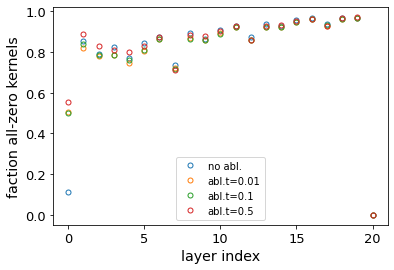

In [118]:
la= {'us1p7psr': 'no abl.', '8m2ytv3b': 'abl.t=0.01', 'ek5wjcyn': 'abl.t=0.1', 'f75f6a5m': 'abl.t=0.5'}
ma= {'us1p7psr': '.', 
'8m2ytv3b': '.', 
'ek5wjcyn': '.', 
'f75f6a5m': '.'}

fig, ax = plt.subplots(1,1, figsize=(6,4))

for k, v in zkf.items():
    ax.plot(v, label=la[k], linestyle='', marker=ma[k], markersize=10, markerfacecolor='none')

ax.legend()
ax.set_xlabel('layer index')
ax.set_ylabel('faction all-zero kernels')

plt.savefig('ablations.png', format='png', dpi=200, facecolor='white', edgecolor='white')

In [134]:
pruner.dynamically_ablated_neuron_idx

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

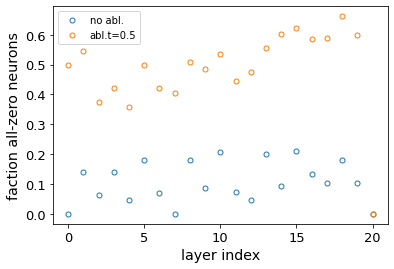

In [133]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

for k in ['us1p7psr', 'f75f6a5m']:
#, v in NumZeroFilters.items():
    v= NumZeroFilters[k]
    p= [v[i]/pruner.W[i].shape[0] for i in range(len(v))]
    
    ax.plot(p, label=la[k], linestyle='', marker=ma[k], markersize=10, markerfacecolor='none')

ax.legend()
ax.set_xlabel('layer index')
ax.set_ylabel('faction all-zero neurons')

plt.savefig('ablations_neurons.png', format='png', dpi=200, facecolor='white', edgecolor='white')

In [ ]:
    
import matplotlib.pyplot as plt
%matplotlib inline
lrs=[]
for _ in list(range(1,149)):
    scheduler.step()
    lrs.append(scheduler.get_last_lr())

plt.plot(lrs)

In [ ]:
scheduler_state_dict, optimizer_state_dict = checkpoint.get_state()["scheduler"], checkpoint.get_state()["optimizer"]

In [ ]:
new_optim = get_optimizer(cfg, model, optimizer_state_dict)
ckp_scheduler= get_lr_scheduler(cfg, new_optim, state_dict=scheduler_state_dict)

In [ ]:
ckp_scheduler.state_dict()

In [ ]:
    
import matplotlib.pyplot as plt
%matplotlib inline
lrs=[]
for _ in list(range(149,501)):
    ckp_scheduler.step()
    lrs.append(ckp_scheduler.get_last_lr())

plt.plot(lrs)

In [ ]:
ckp_scheduler.__dict__

In [ ]:
import matplotlib.pyplot as plt

lrs = []
for epoch in list(range(1,150)):
    scheduler.step()
    lrs.append(scheduler.get_last_lr())
print(lrs)
plt.plot(lrs)

In [ ]:
pruner.__str__()

In [ ]:
# net = ModelFactory.load_model("wide_resnet22", "cifar10")
model = ModelFactory.load_model("resnet50", "imagenet")
device = torch.device("cuda:0")
train_loader, test_loader = get_dataloaders(cfg)
# model = ModelFactory.load_model(
#         model=cfg.model.name, dataset=cfg.dataset.name
#     )
model.to(device)
optimizer = get_optimizer(cfg, model, state_dict=None)
scheduler = get_lr_scheduler(cfg, optimizer, state_dict=None)
T_end = get_T_end(cfg, train_loader)
if cfg.rigl.const_fan_in:
    rigl_scheduler = RigLConstFanScheduler
else:
    rigl_scheduler = RigLScheduler
# pruner = rigl_scheduler(
#     model,
#     optimizer,
#     dense_allocation=cfg.rigl.dense_allocation,
#     alpha=cfg.rigl.alpha,
#     delta=cfg.rigl.delta,
#     static_topo=cfg.rigl.static_topo,
#     T_end=T_end,
#     ignore_linear_layers=False,
#     grad_accumulation_n=cfg.rigl.grad_accumulation_n,
#     sparsity_distribution=cfg.rigl.sparsity_distribution,
#     erk_power_scale=cfg.rigl.erk_power_scale,
#     state_dict=None,
#     filter_ablation_threshold=cfg.rigl.filter_ablation_threshold,
#     static_ablation=cfg.rigl.static_ablation,
#     dynamic_ablation=cfg.rigl.dynamic_ablation,
#     min_salient_weights_per_neuron=cfg.rigl.min_salient_weights_per_neuron,
#     )

In [ ]:
pruner(
    
)